In [1]:
from financeiro import FinancialData
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from algo_trade import (
    long_short_invest,
    get_ema_cols,
    get_macd,
    get_montante,
    get_return_info,
    get_info_invest
)
import warnings
import numpy as np
warnings.filterwarnings('ignore')

## Funções

In [2]:
def plot_long_short(df, short, long):
    posi = [(0,0), (0,1), (0,2), (1, 0), (1, 1)]
    fig, axs = plt.subplots(2, 3, figsize=(40, 30))
    plt.style.use('seaborn-whitegrid')                               
    for each, pos in zip(df.columns, posi):                                           
        ativo = each                                             
        axs[pos[0], pos[1]].plot(short.index, short[ativo],                      
        color='green', label='Short')                             
        axs[pos[0], pos[1]].plot(long.index, long[ativo],                        
        color='b', label='Long')                                  
        axs[pos[0], pos[1]].set_title("Médias {}".format(each))                                
        axs[pos[0], pos[1]].legend(loc='upper left', fontsize=20)                           

In [3]:
def plot_buy_sell_long_short(df, short, long, long_short_diff):
    posi = [(0,0), (0,1), (0,2), (1, 0), (1, 1)]
    fig, axs = plt.subplots(2, 3, figsize=(40, 30))
    plt.style.use('seaborn-whitegrid')                                 
    for each, pos in zip(df.columns, posi):                                           
        ativo = each                                                       
        axs[pos[0], pos[1]].plot(short[ativo], label='Short')                         
        axs[pos[0], pos[1]].plot(long[ativo], label='Long')                           
        axs[pos[0], pos[1]].set_ylabel("Preço [R$]", fontsize=25)                              
        axs[pos[0], pos[1]].set_xlabel("Data", fontsize=25)                                    
        axs[pos[0], pos[1]].set_title("Médias {}".format(each), fontsize=25)
        filter_buy = long_short_diff[long_short_diff[ativo] == "buy"].index
        axs[pos[0], pos[1]].plot(short[ativo][short[ativo].index.isin(filter_buy)].index,
                 short[ativo][short[ativo].index.isin(filter_buy)],     
        '^', markersize=10, color='m', label='Buy')
        filter_sell = long_short_diff[long_short_diff[ativo] == "sell"].index
        axs[pos[0], pos[1]].plot(short[ativo][short[ativo].index.isin(filter_sell)].index,                    
                 short[ativo][short[ativo].index.isin(filter_sell)],    
        'v', markersize=10, color='k', label='Sell')               
        axs[pos[0], pos[1]].legend(loc='upper left', fontsize=25)                          

In [4]:
def plot_buy_sell_macd(df):
    posi = [(0,0), (0,1), (0,2), (1, 0), (1, 1)]
    fig, axs = plt.subplots(2, 3, figsize=(40, 30))
    plt.style.use('seaborn-whitegrid')                                 
    for each, pos in zip(df.keys(), posi):                                           
        ativo = each                                                       
        axs[pos[0], pos[1]].plot(df[ativo][ativo], label='close')                                                 
        axs[pos[0], pos[1]].set_ylabel("Preço [R$]", fontsize=25)                              
        axs[pos[0], pos[1]].set_xlabel("Data", fontsize=25)                                    
        axs[pos[0], pos[1]].set_title("Médias {}".format(each), fontsize=25)
        filter_buy = df[ativo][ativo][df[ativo]["position"] == 1.0].index
        axs[pos[0], pos[1]].plot(df[ativo][ativo][df[ativo][ativo].index.isin(filter_buy)].index,
                 df[ativo][ativo][df[ativo][ativo].index.isin(filter_buy)],     
        '^', markersize=10, color='m', label='Buy')
        filter_sell = df[ativo][ativo][df[ativo]["position"] == -1.0].index
        axs[pos[0], pos[1]].plot(df[ativo][ativo][df[ativo][ativo].index.isin(filter_sell)].index,                    
                 df[ativo][ativo][df[ativo][ativo].index.isin(filter_sell)],    
        'v', markersize=10, color='k', label='Sell')               
        axs[pos[0], pos[1]].legend(loc='upper left', fontsize=25)   

## Extraindo dado

In [5]:
ativos = ["IRBR3.SA", "AAPL34.SA", "CSNA3.SA", "CESP6.SA", "TEND3.SA"]

In [6]:
fi = FinancialData()

In [7]:
# date_train = ("2017-11-03", "2019-11-03")
# date_test = ("2019-11-03", "2020-11-03")
# train = fi.extract_data_from_actives(ativos, date_train, "yahoo")
# test = fi.extract_data_from_actives(ativos, date_test, "yahoo")

In [8]:
# train.to_csv("train.csv")
# test.to_csv("test.csv")

In [9]:
train = pd.read_csv("train.csv", index_col=["Date"])
test = pd.read_csv("test.csv", index_col=["Date"])

In [10]:
train.head()

,IRBR3.SA,AAPL34.SA,CSNA3.SA,CESP6.SA,TEND3.SA
Date,,,,,
2017-11-03,10.332370,12.292687,6.622097,11.140564,8.196823
2017-11-06,10.492818,12.351051,6.970628,11.328478,7.918885
2017-11-07,10.495966,12.405088,6.671887,11.006340,7.848224
2017-11-08,10.675483,12.431026,6.862750,11.409012,7.914174
2017-11-09,10.637805,12.465922,6.514218,11.051082,7.867068


In [11]:
test.head()

,IRBR3.SA,AAPL34.SA,CSNA3.SA,CESP6.SA,TEND3.SA
Date,,,,,
2019-11-04,36.788086,25.170553,12.074782,27.723089,25.334667
2019-11-05,36.845207,25.067837,12.284345,27.797264,25.207506
2019-11-06,36.188278,25.427347,12.274364,27.852898,25.315102
2019-11-07,34.607838,26.251709,12.573739,27.389301,25.217289
2019-11-08,33.417744,26.952513,12.274364,27.630369,24.962963


## Verificando qualidade do dado

<AxesSubplot:ylabel='Date'>

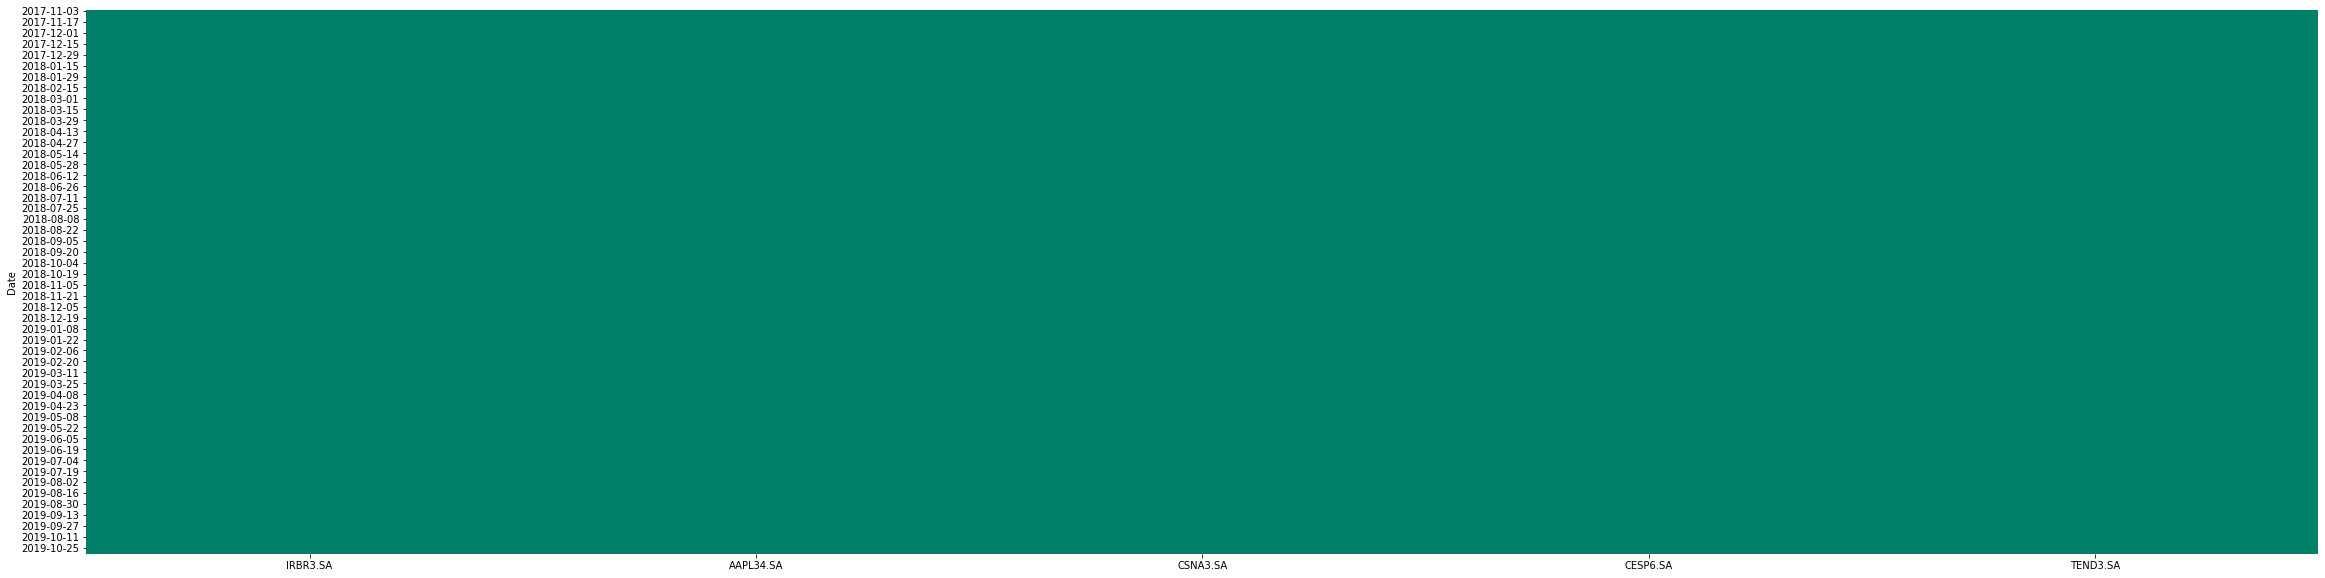

In [12]:
fi.plot_data_segmentation(train)

<AxesSubplot:ylabel='Date'>

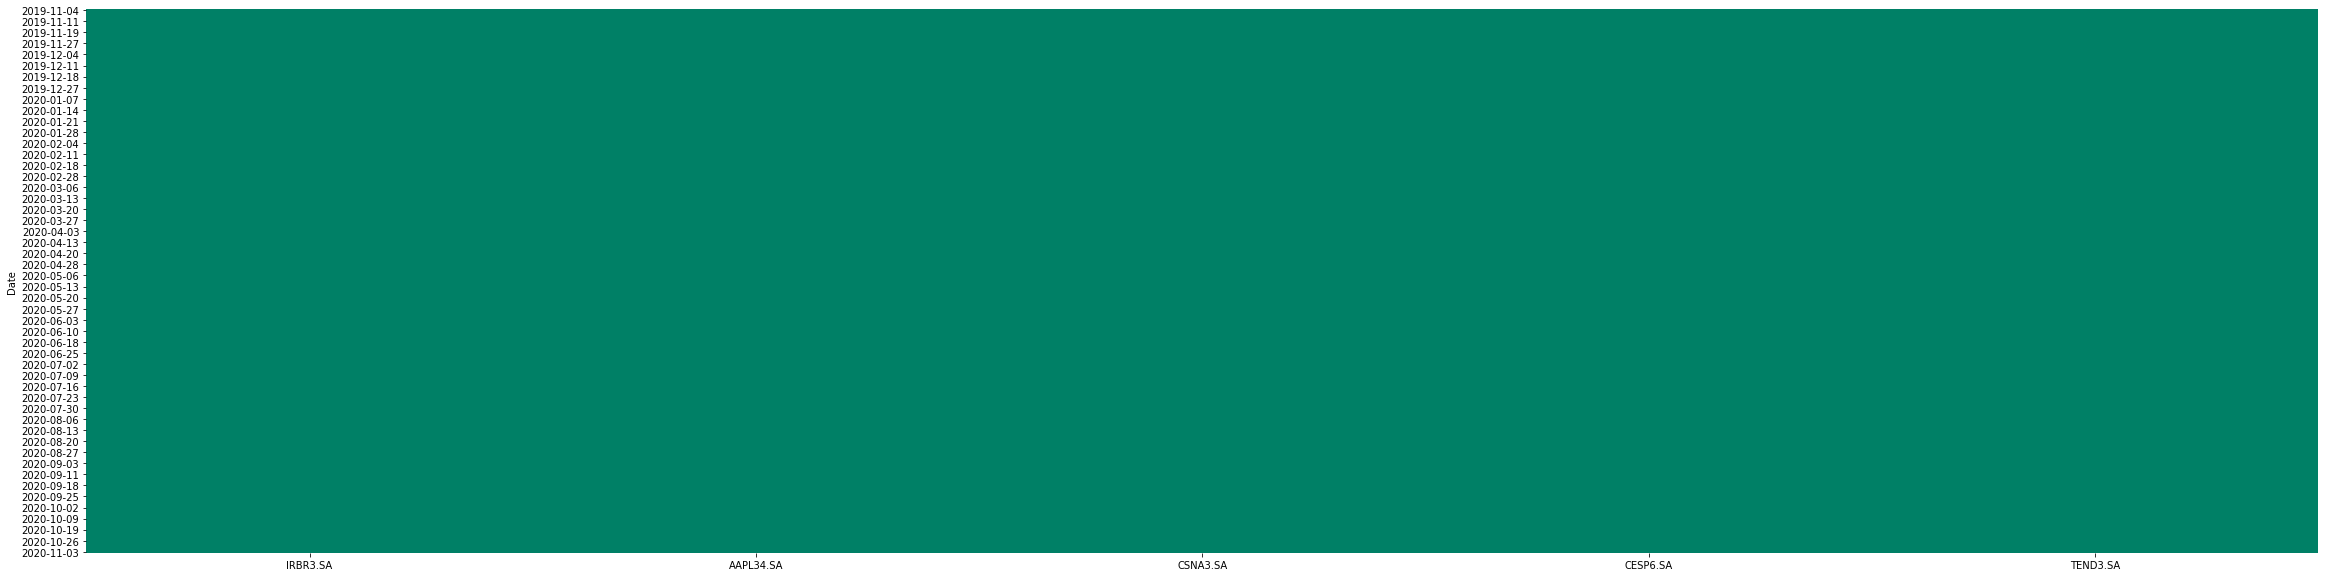

In [13]:
fi.plot_data_segmentation(test)

## Processando dados

In [14]:
train = train.dropna()
test = test.dropna()

# Questão 01

## Média móvel curta e longa

In [15]:
window_s = 3
window_l = 6
capital = 100000

## Train

In [16]:
short, long, long_short, long_short_diff, _ = long_short_invest(train, 3, 6, capital)

100%|██████████| 5/5 [00:00<00:00, 601.09it/s]
5it [00:00, 1443.13it/s]

IRBR3.SA: 1407.8
AAPL34.SA: 4144.1
CSNA3.SA: -581.24
CESP6.SA: 5260.28
TEND3.SA: 1083.82
Total de lucro da carteira: 11314.75


In [17]:
long_short_diff.shape

(489, 5)

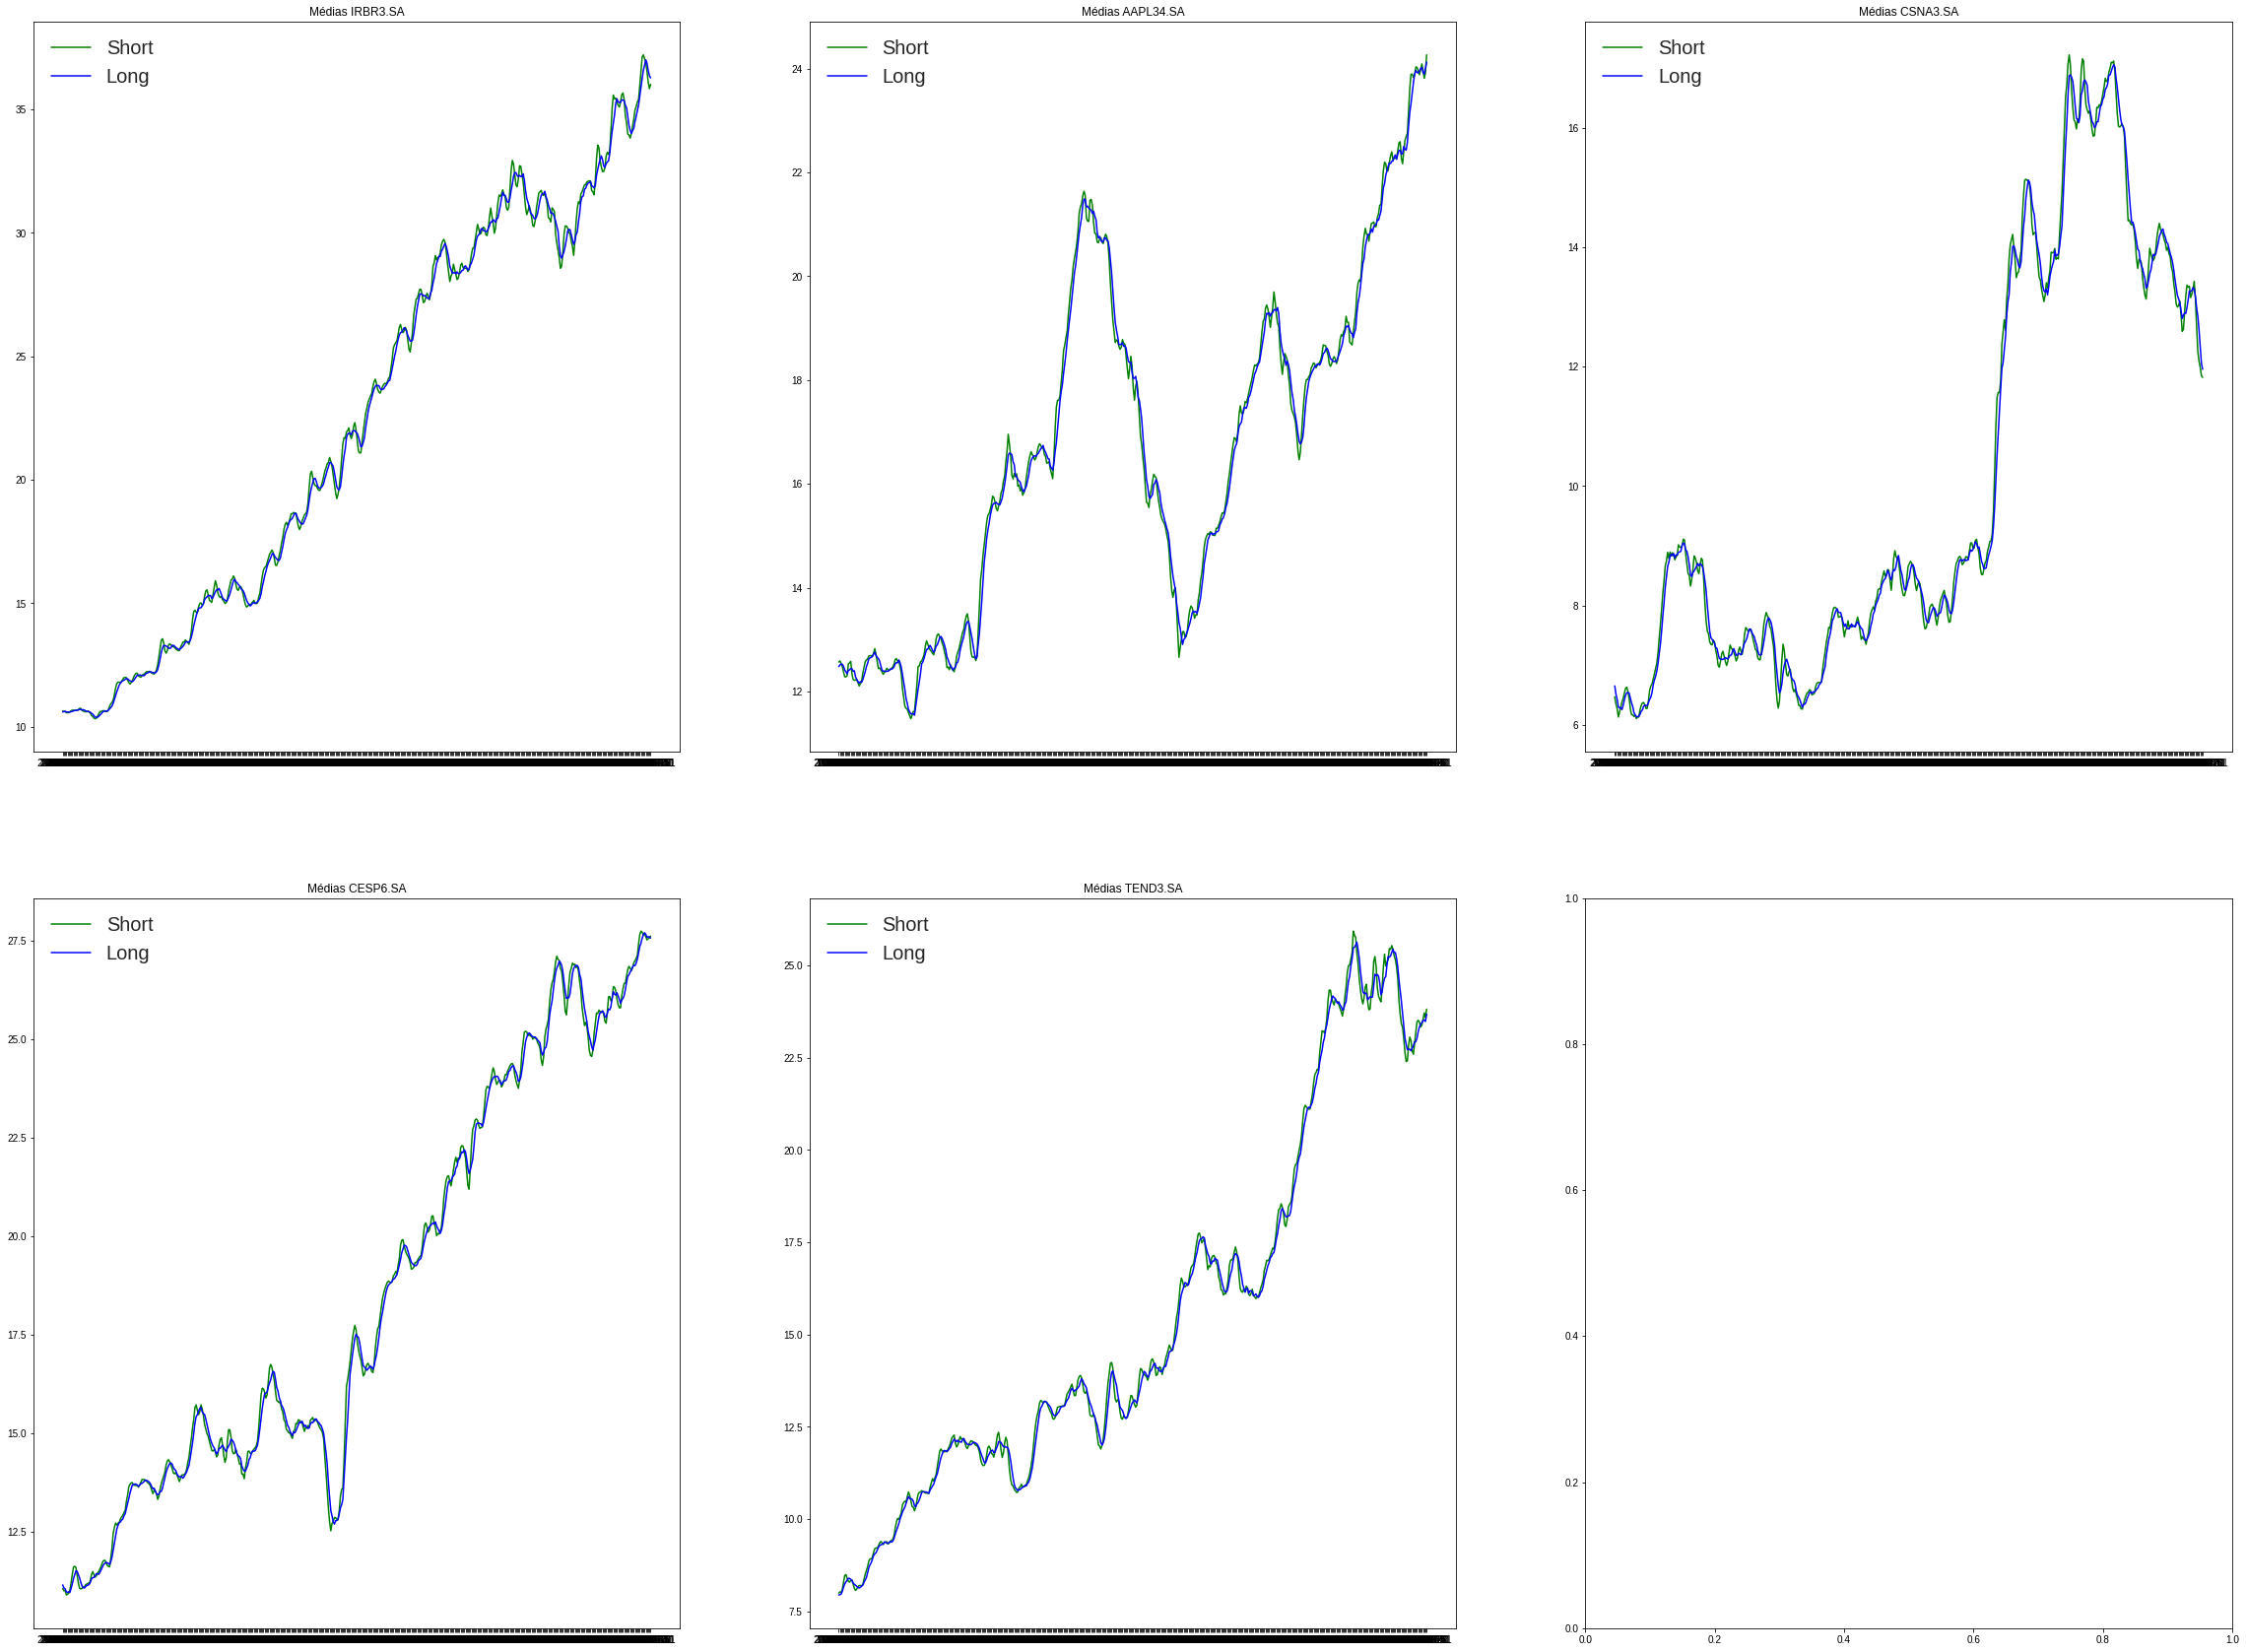

In [18]:
plot_long_short(train, short, long)

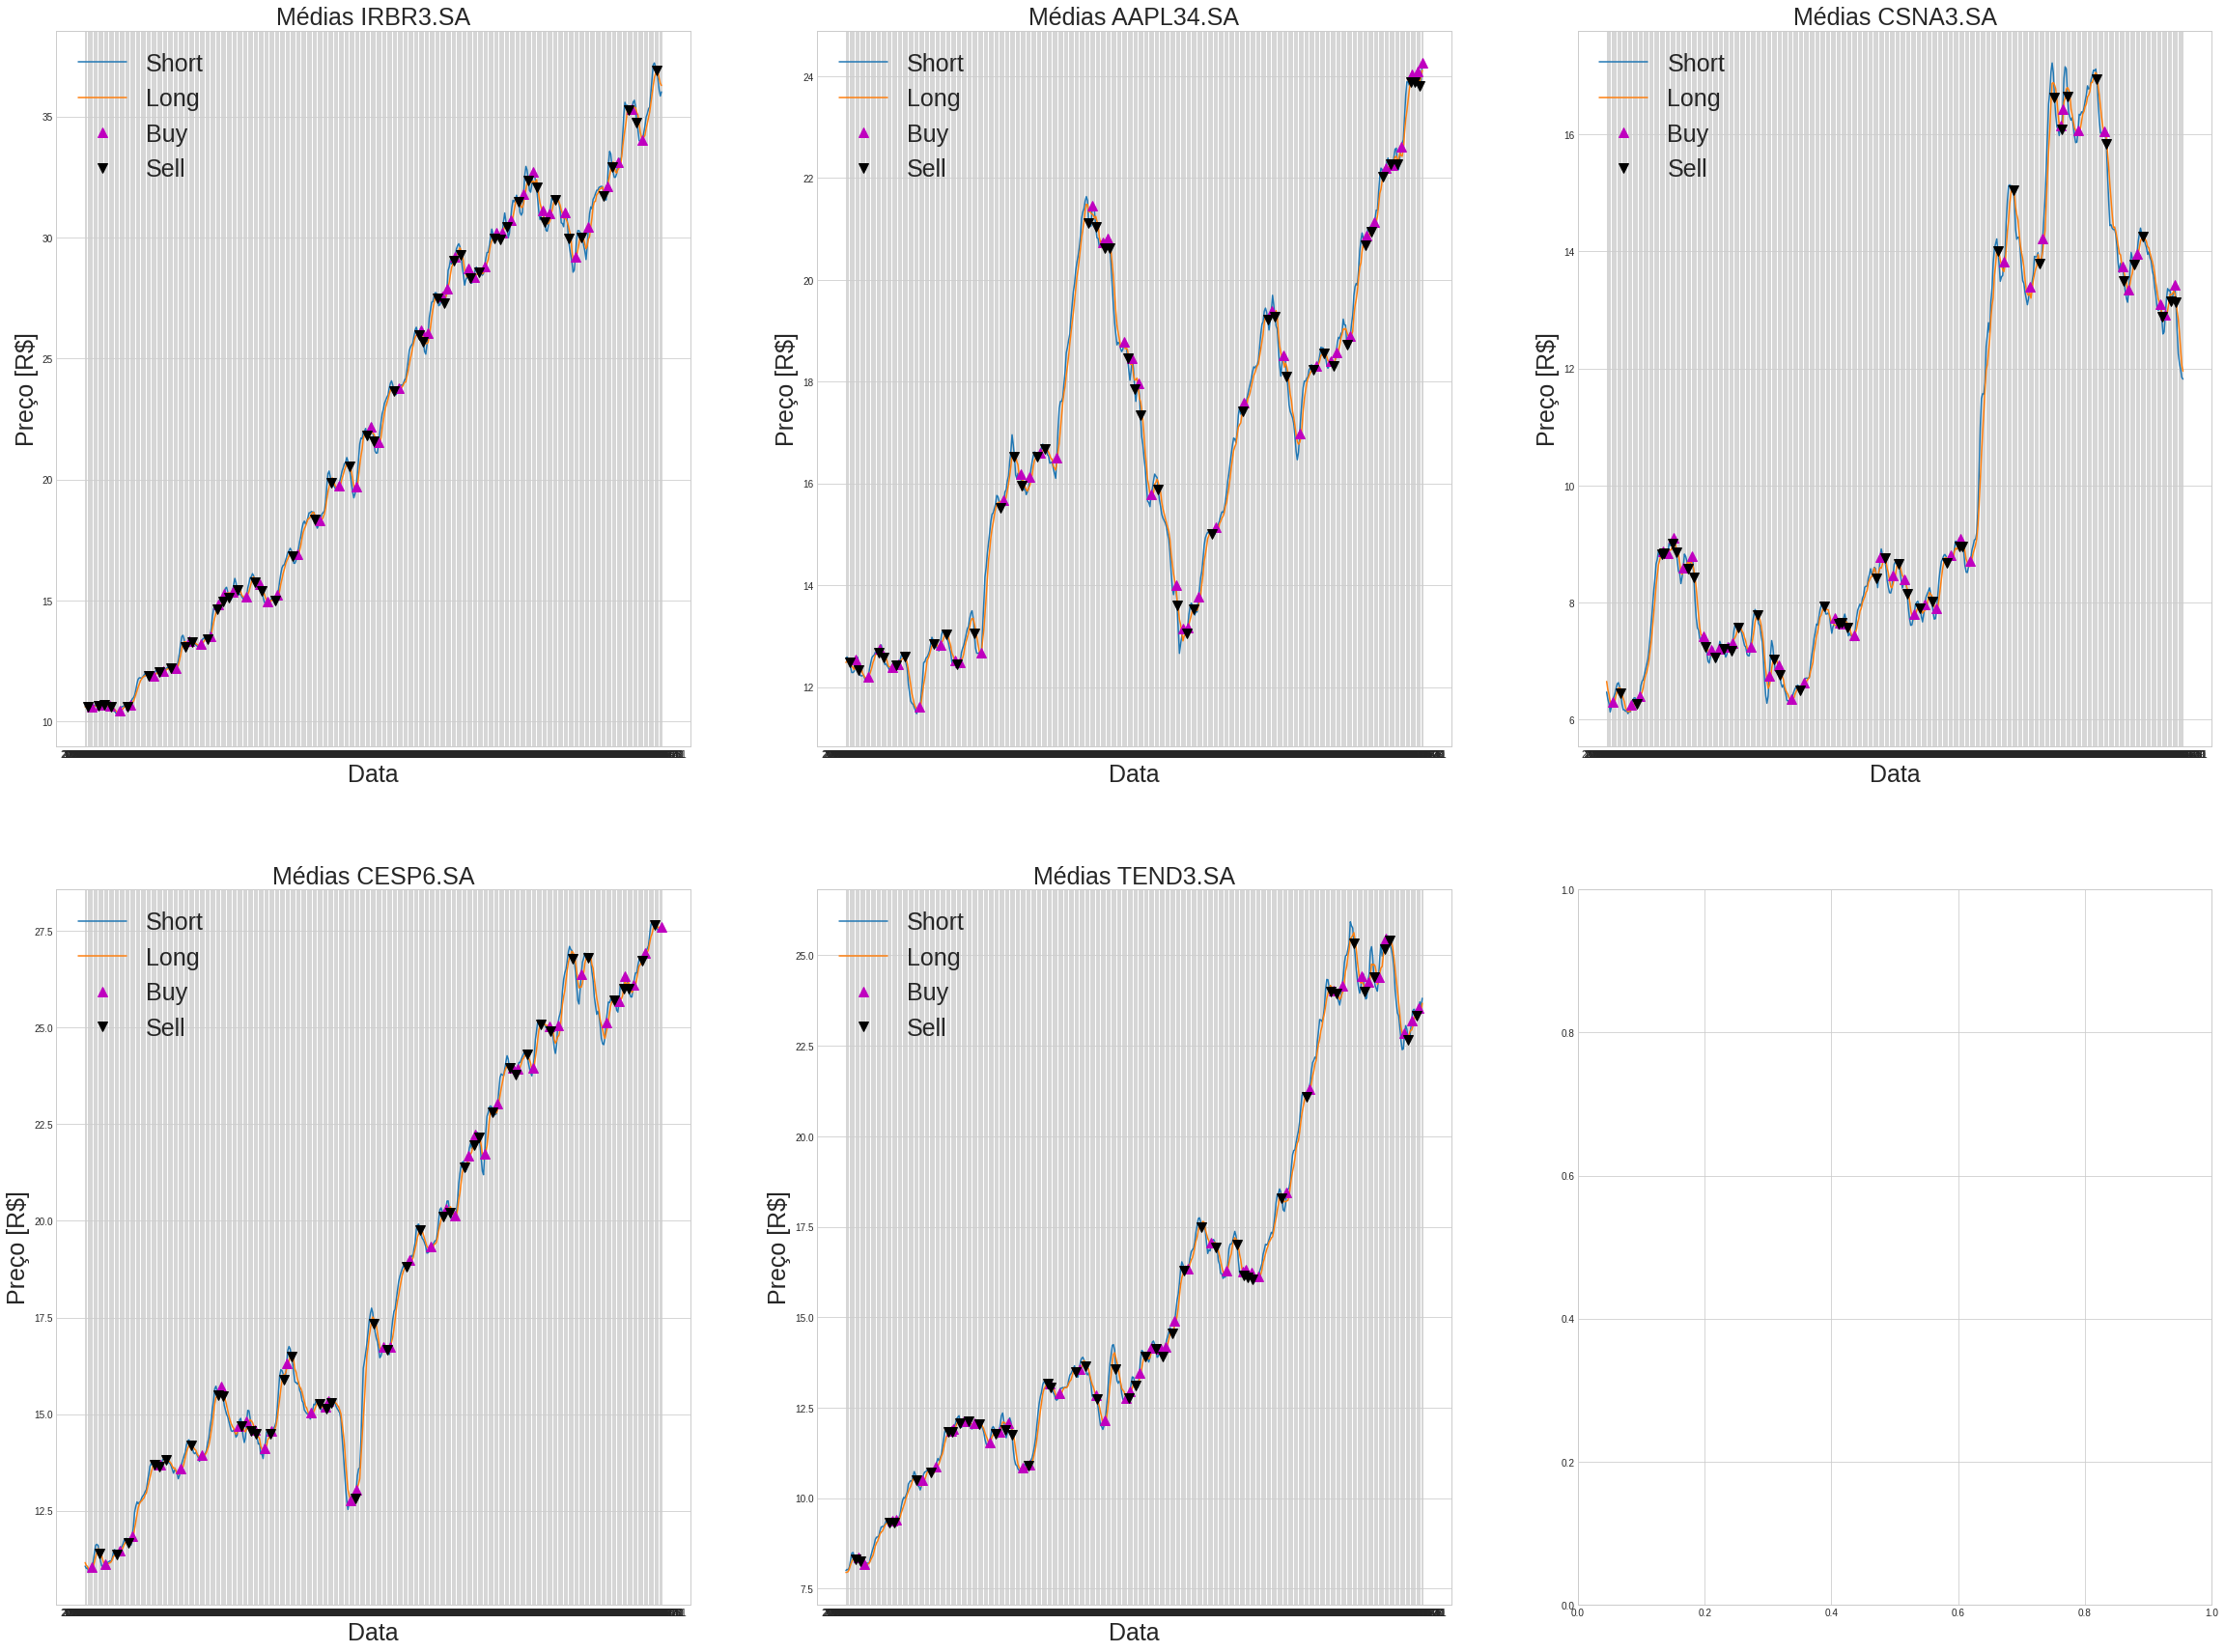

In [19]:
plot_buy_sell_long_short(train, short, long, long_short_diff)

## Test

In [20]:
short_t, long_t, long_short_t, long_short_diff_t, alls = long_short_invest(test, 3, 6, capital)

100%|██████████| 5/5 [00:00<00:00, 409.38it/s]
5it [00:00, 944.54it/s]

IRBR3.SA: -2546.39
AAPL34.SA: 14381.54
CSNA3.SA: 99.49
CESP6.SA: -600.53
TEND3.SA: -137.8
Total de lucro da carteira: 11196.3


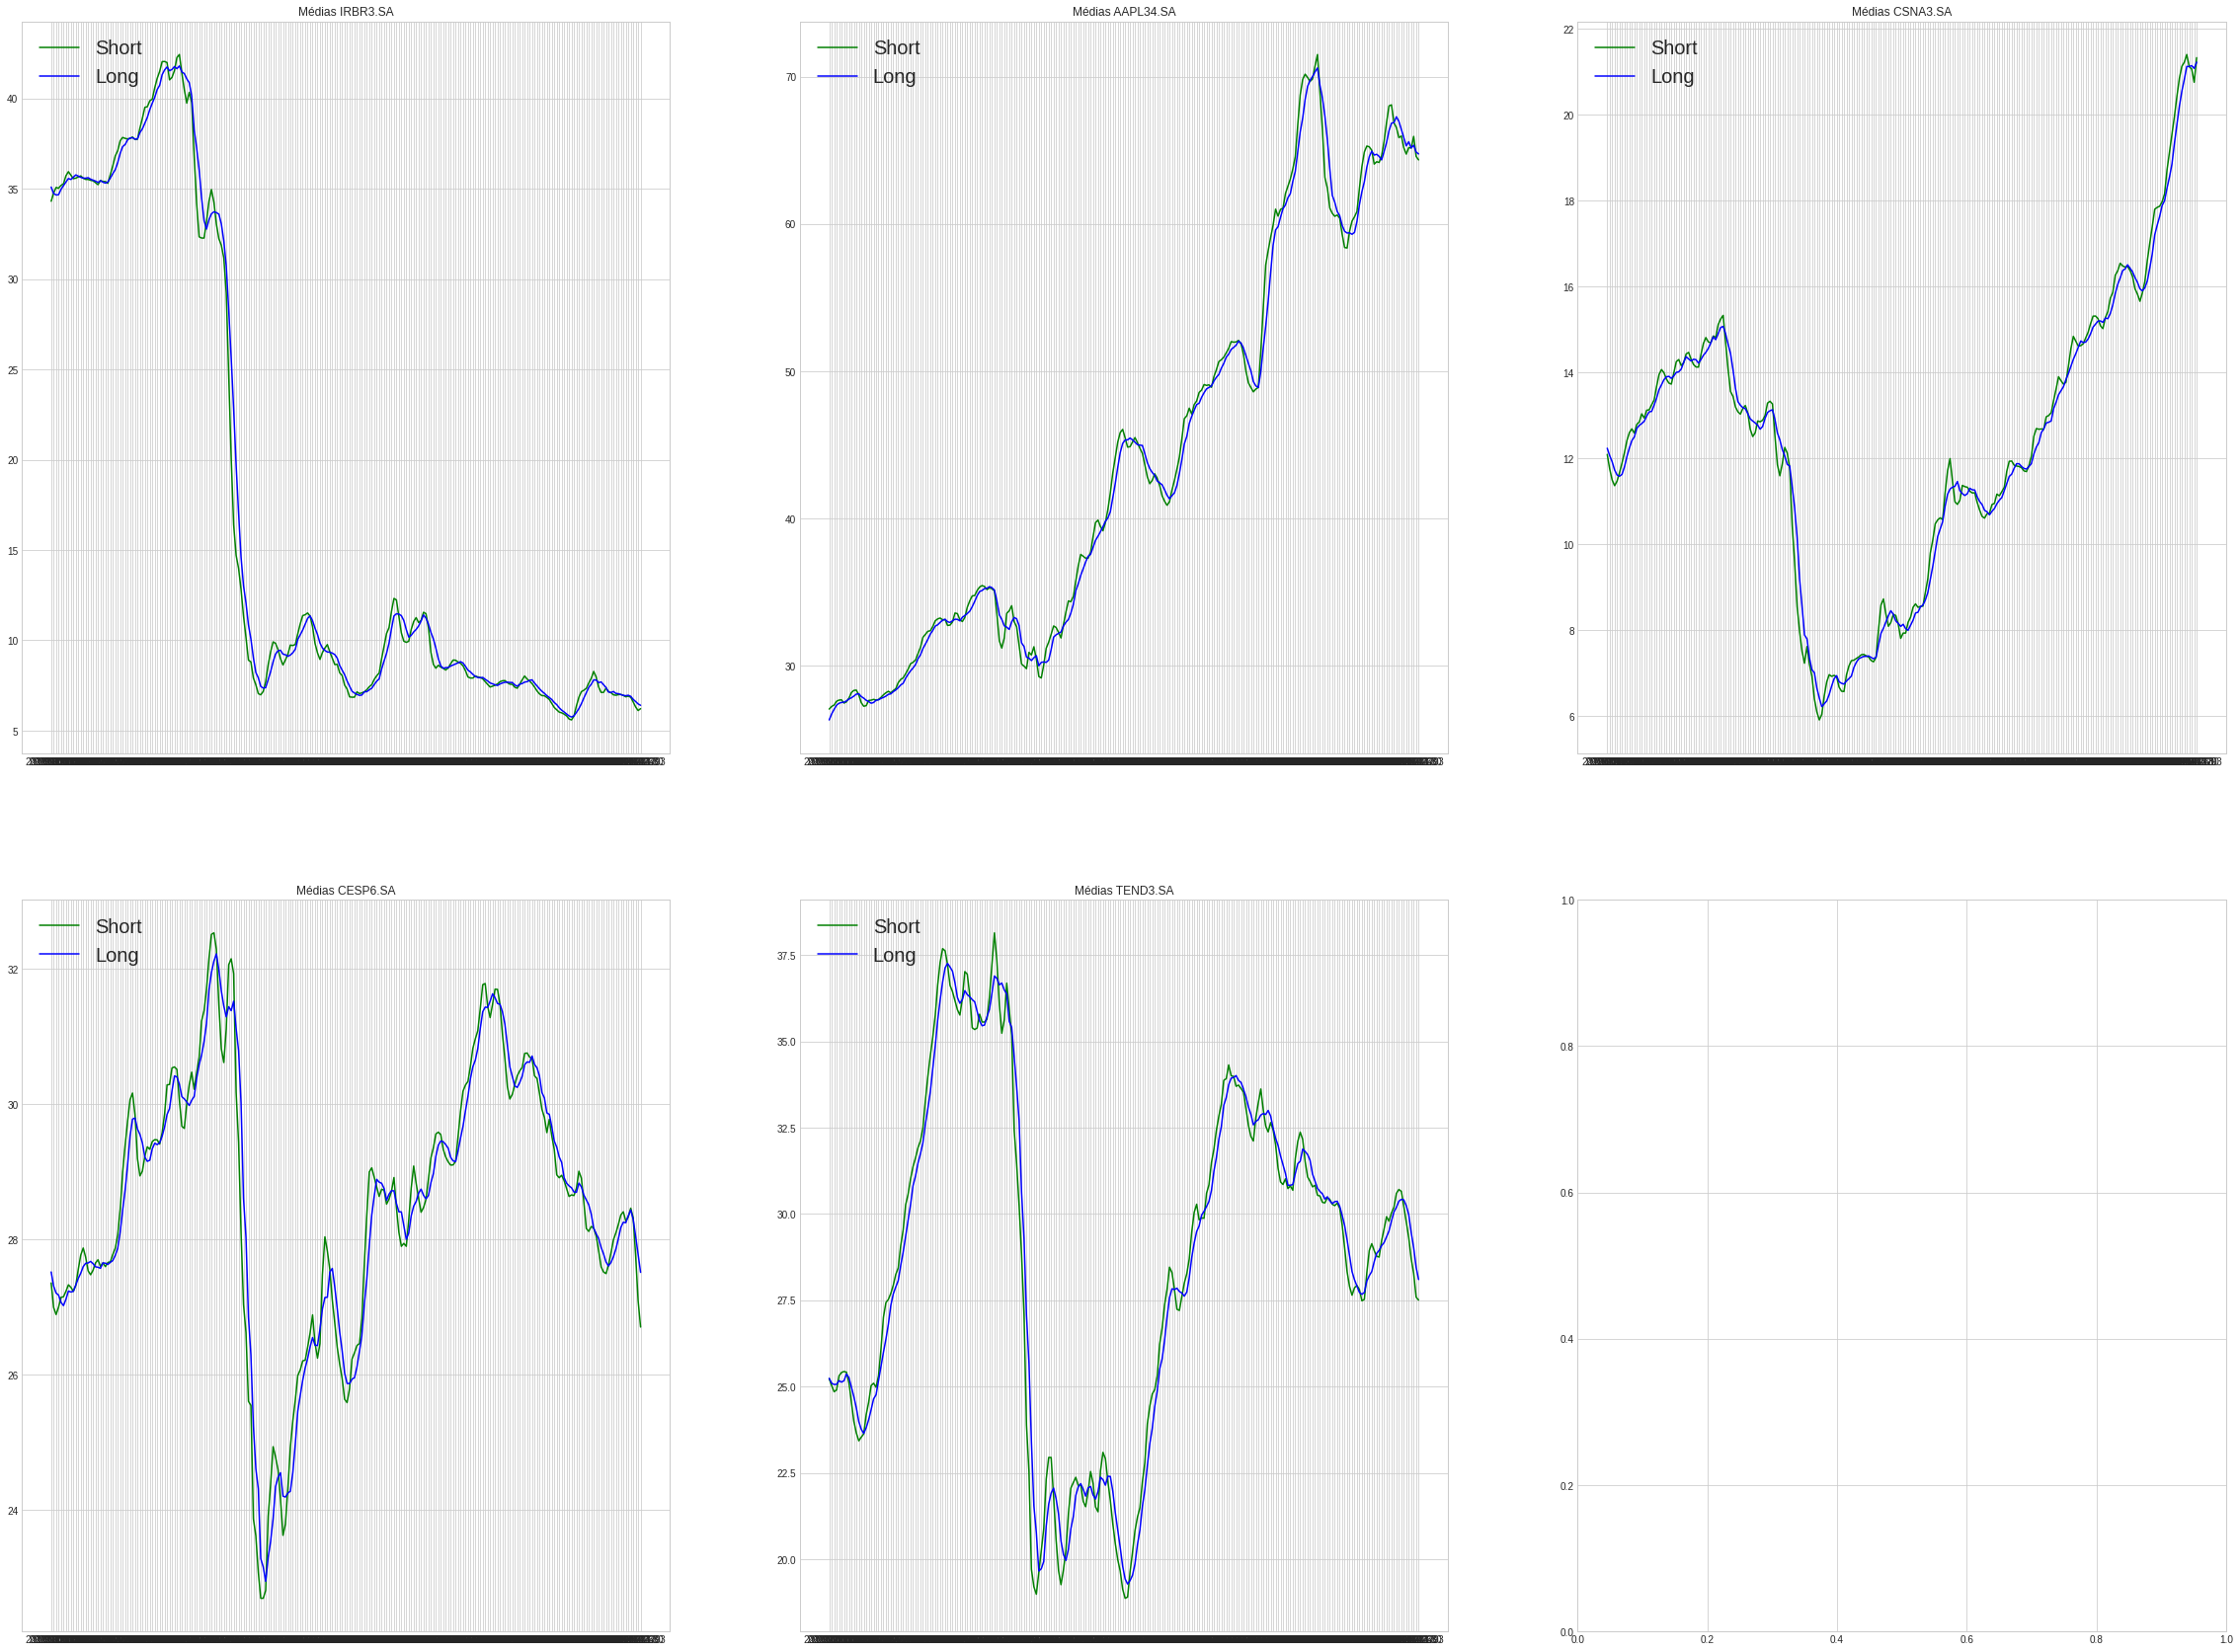

In [21]:
plot_long_short(test, short_t, long_t)

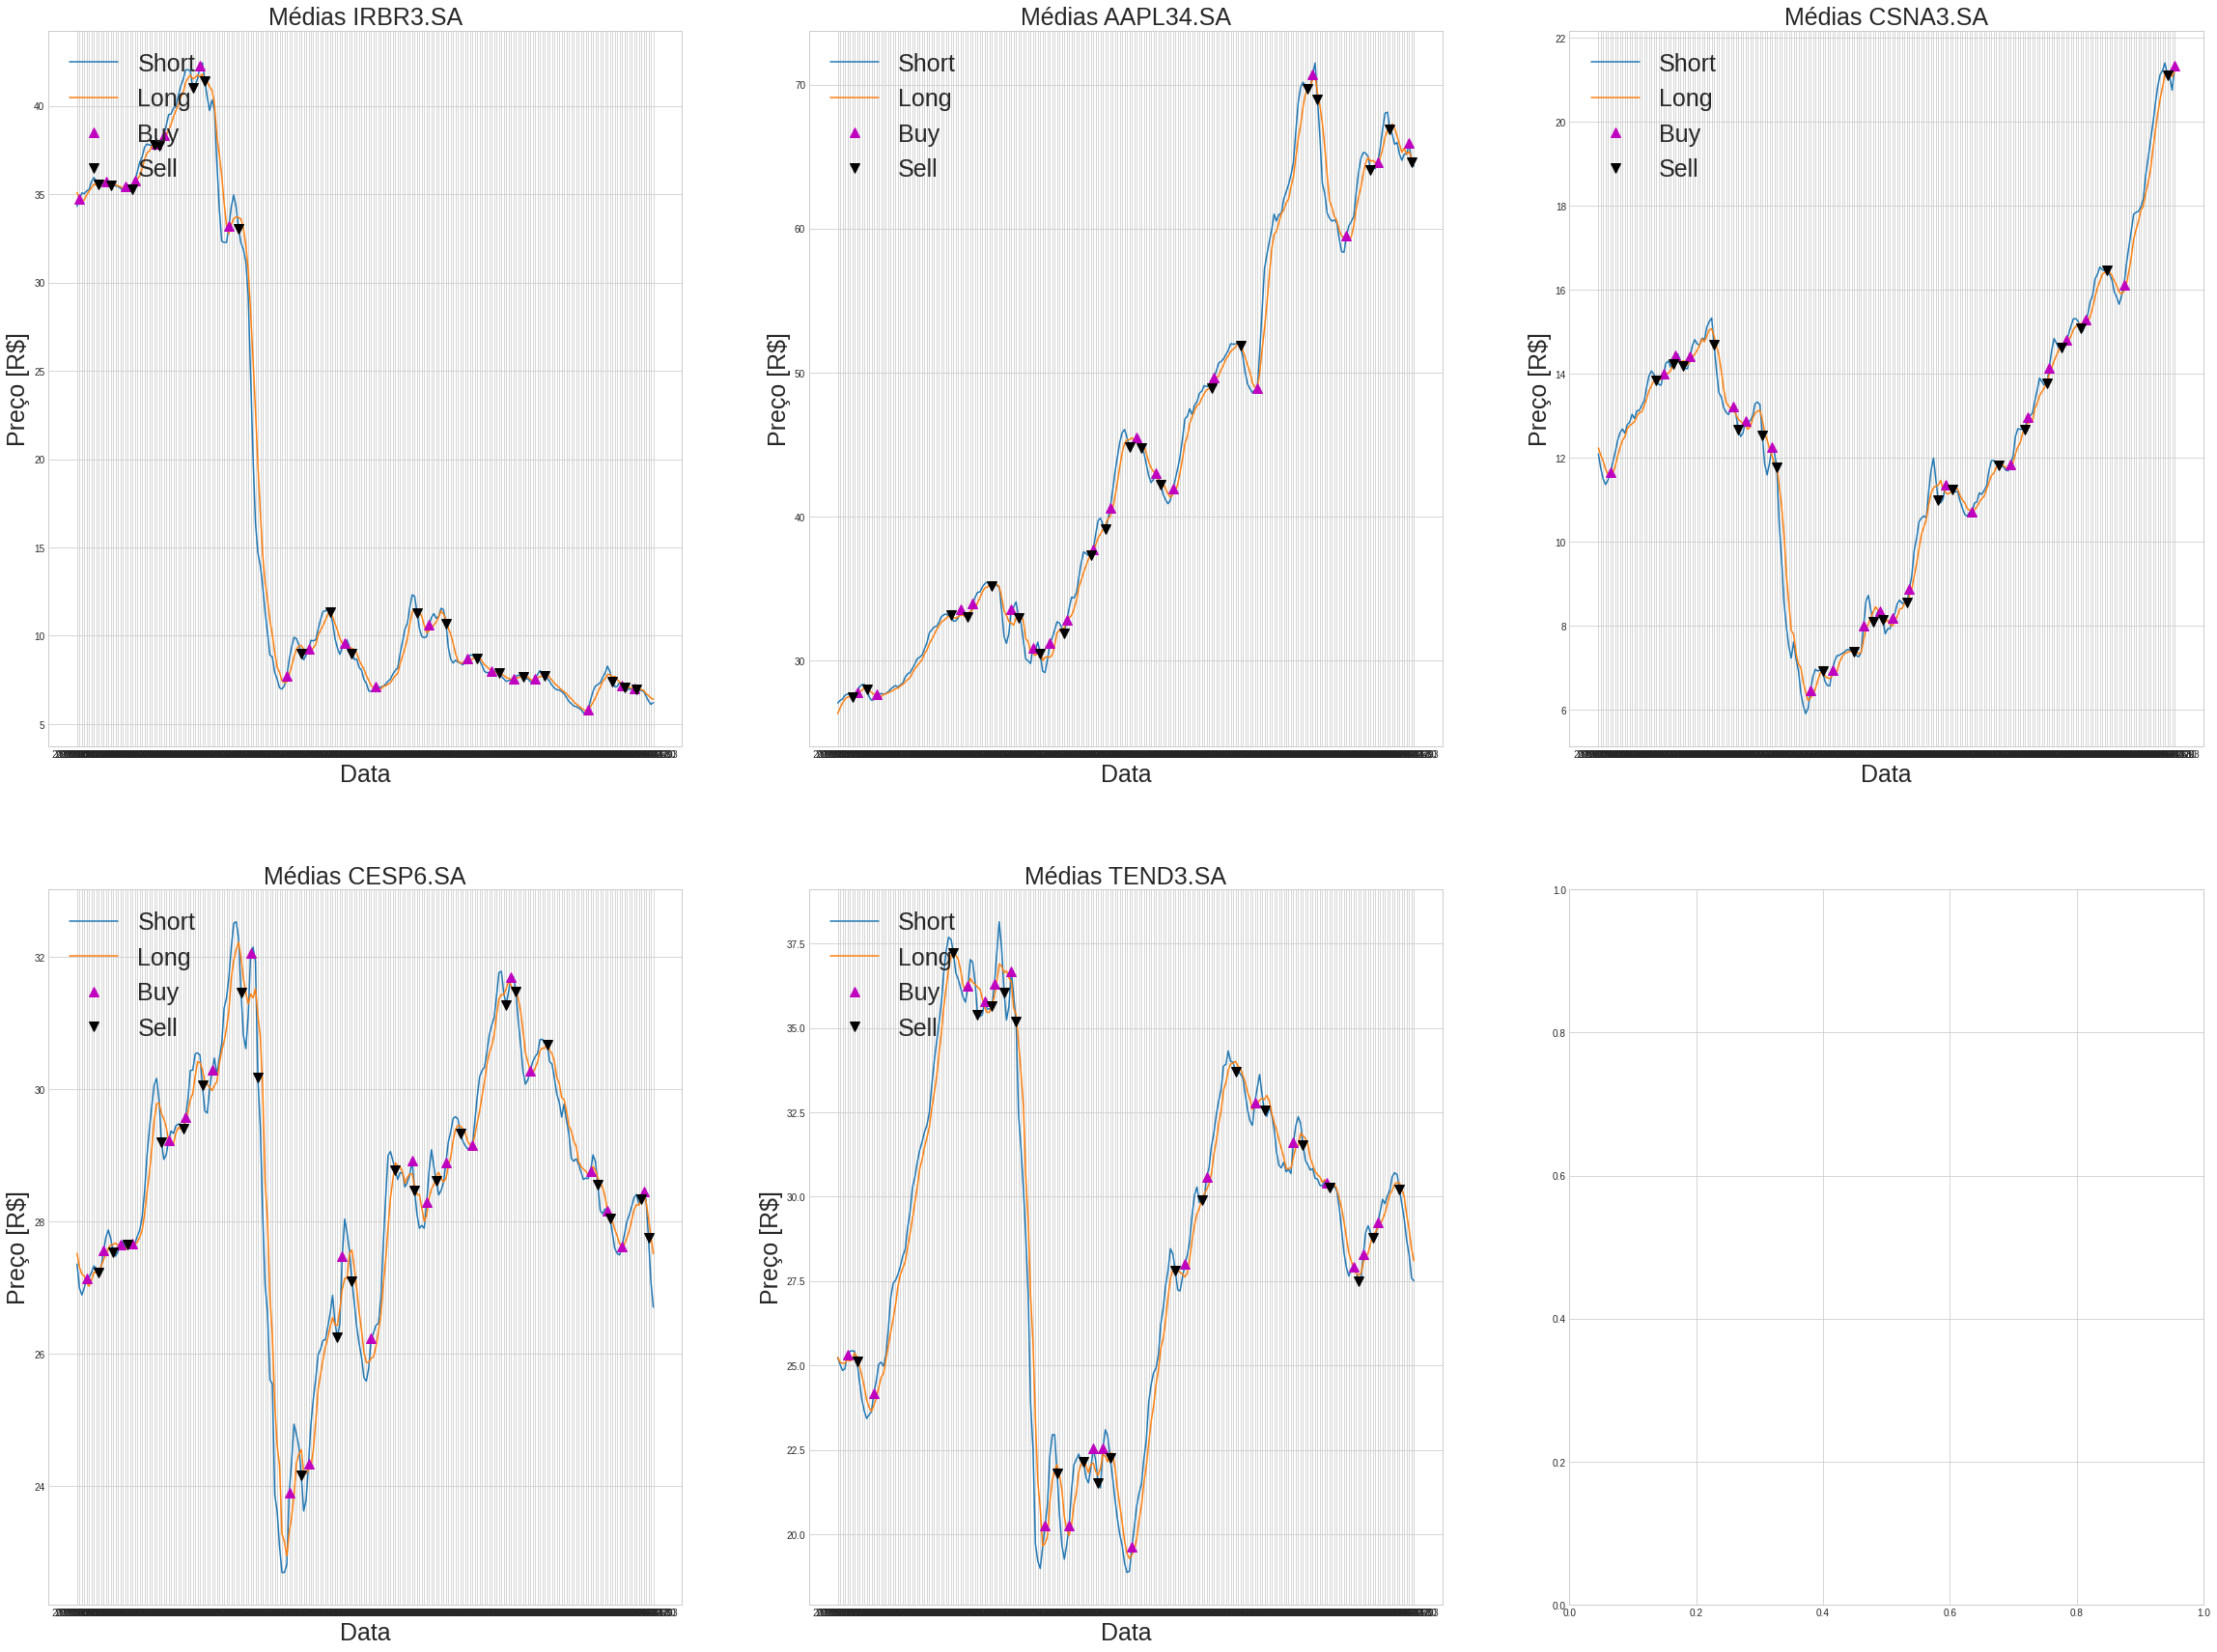

In [22]:
plot_buy_sell_long_short(test, short_t, long_t, long_short_diff_t)

In [23]:
trades = 0
for each in ativos:
    print("ATIVO: {}   TRADES: {}".format(each, long_short_diff_t[each][long_short_diff_t[each] != 0].shape[0]))
    trades += long_short_diff_t[each][long_short_diff_t[each] != 0].shape[0]
print("Total trades: {}".format(trades))

ATIVO: IRBR3.SA   TRADES: 40
ATIVO: AAPL34.SA   TRADES: 39
ATIVO: CSNA3.SA   TRADES: 43
ATIVO: CESP6.SA   TRADES: 44
ATIVO: TEND3.SA   TRADES: 38
Total trades: 204


In [24]:
total_acc = 0
total_trades = 0
for each in ativos:
    acc_buy = alls[each][(alls[each]["action"] == "buy") & (alls[each]["return"] <= 0)].shape[0]
    acc_sell = alls[each][(alls[each]["action"] == "sell") & (alls[each]["return"] > 0)].shape[0]
    trades = alls[each].shape[0]
    total_trades += trades
    total_acc += acc_buy + acc_sell
    
print("TOTAL TRADES: {}\nTOTAL ACC: {}\nPERC_ACC: {}%\n".format(total_trades, total_acc, round((total_acc/total_trades)*100)))

TOTAL TRADES: 204
TOTAL ACC: 79
PERC_ACC: 39%



# Questão 02

## Aplicando MACD

In [25]:
split_train = fi.split_data_by_name(train)
split_test = fi.split_data_by_name(test)

In [26]:
window_signal = 9
for ativo in tqdm(train.columns):
    split_train[ativo]["short"], split_train[ativo]["long"] = get_ema_cols(split_train[ativo], window_s, window_l)
    split_train[ativo]["macd"], split_train[ativo]["macd_signal"] = get_macd(split_train[ativo], window_signal)
    
    split_test[ativo]["short"], split_test[ativo]["long"] = get_ema_cols(split_test[ativo], window_s, window_l)
    split_test[ativo]["macd"], split_test[ativo]["macd_signal"] = get_macd(split_test[ativo], window_signal)
    
    split_train[ativo]["signal"] = 0
    split_train[ativo]["signal"] = np.where(
    split_train[ativo]['macd'] > split_train[ativo]['macd_signal'], 1.0, 0.0)
    split_train[ativo]["position"] = split_train[ativo]["signal"].diff()
    
    split_test[ativo]["signal"] = 0
    split_test[ativo]["signal"] = np.where(
    split_test[ativo]['macd'] > split_test[ativo]['macd_signal'], 1.0, 0.0)
    split_test[ativo]["position"] = split_test[ativo]["signal"].diff()
    
    split_train[ativo]["position"].loc[split_train[ativo]["position"].isnull()] = 0
    split_test[ativo]["position"].loc[split_test[ativo]["position"].isnull()] = 0

100%|██████████| 5/5 [00:00<00:00, 32.04it/s]


## Train

In [27]:
posi = [0.08, 0.39, 0.05, 0.35, 0.12]
capital = 100000
get_info_invest(split_train, capital, posi)

ATIVO: IRBR3.SA RETORNO: 1627.52 ACERTO BUY: 3 ACERTO SELL: 11 TOTAL TRADES: 60 PERC_ACERTO: 23.333333333333332
ATIVO: AAPL34.SA RETORNO: 3988.3 ACERTO BUY: 5 ACERTO SELL: 8 TOTAL TRADES: 52 PERC_ACERTO: 25.0
ATIVO: CSNA3.SA RETORNO: -188.86 ACERTO BUY: 6 ACERTO SELL: 7 TOTAL TRADES: 46 PERC_ACERTO: 28.26086956521739
ATIVO: CESP6.SA RETORNO: 5593.64 ACERTO BUY: 4 ACERTO SELL: 12 TOTAL TRADES: 46 PERC_ACERTO: 34.78260869565217
ATIVO: TEND3.SA RETORNO: 1376.22 ACERTO BUY: 5 ACERTO SELL: 10 TOTAL TRADES: 55 PERC_ACERTO: 27.27272727272727
Total de lucro da carteira: 12396.81
Média de acerto: 27.41%


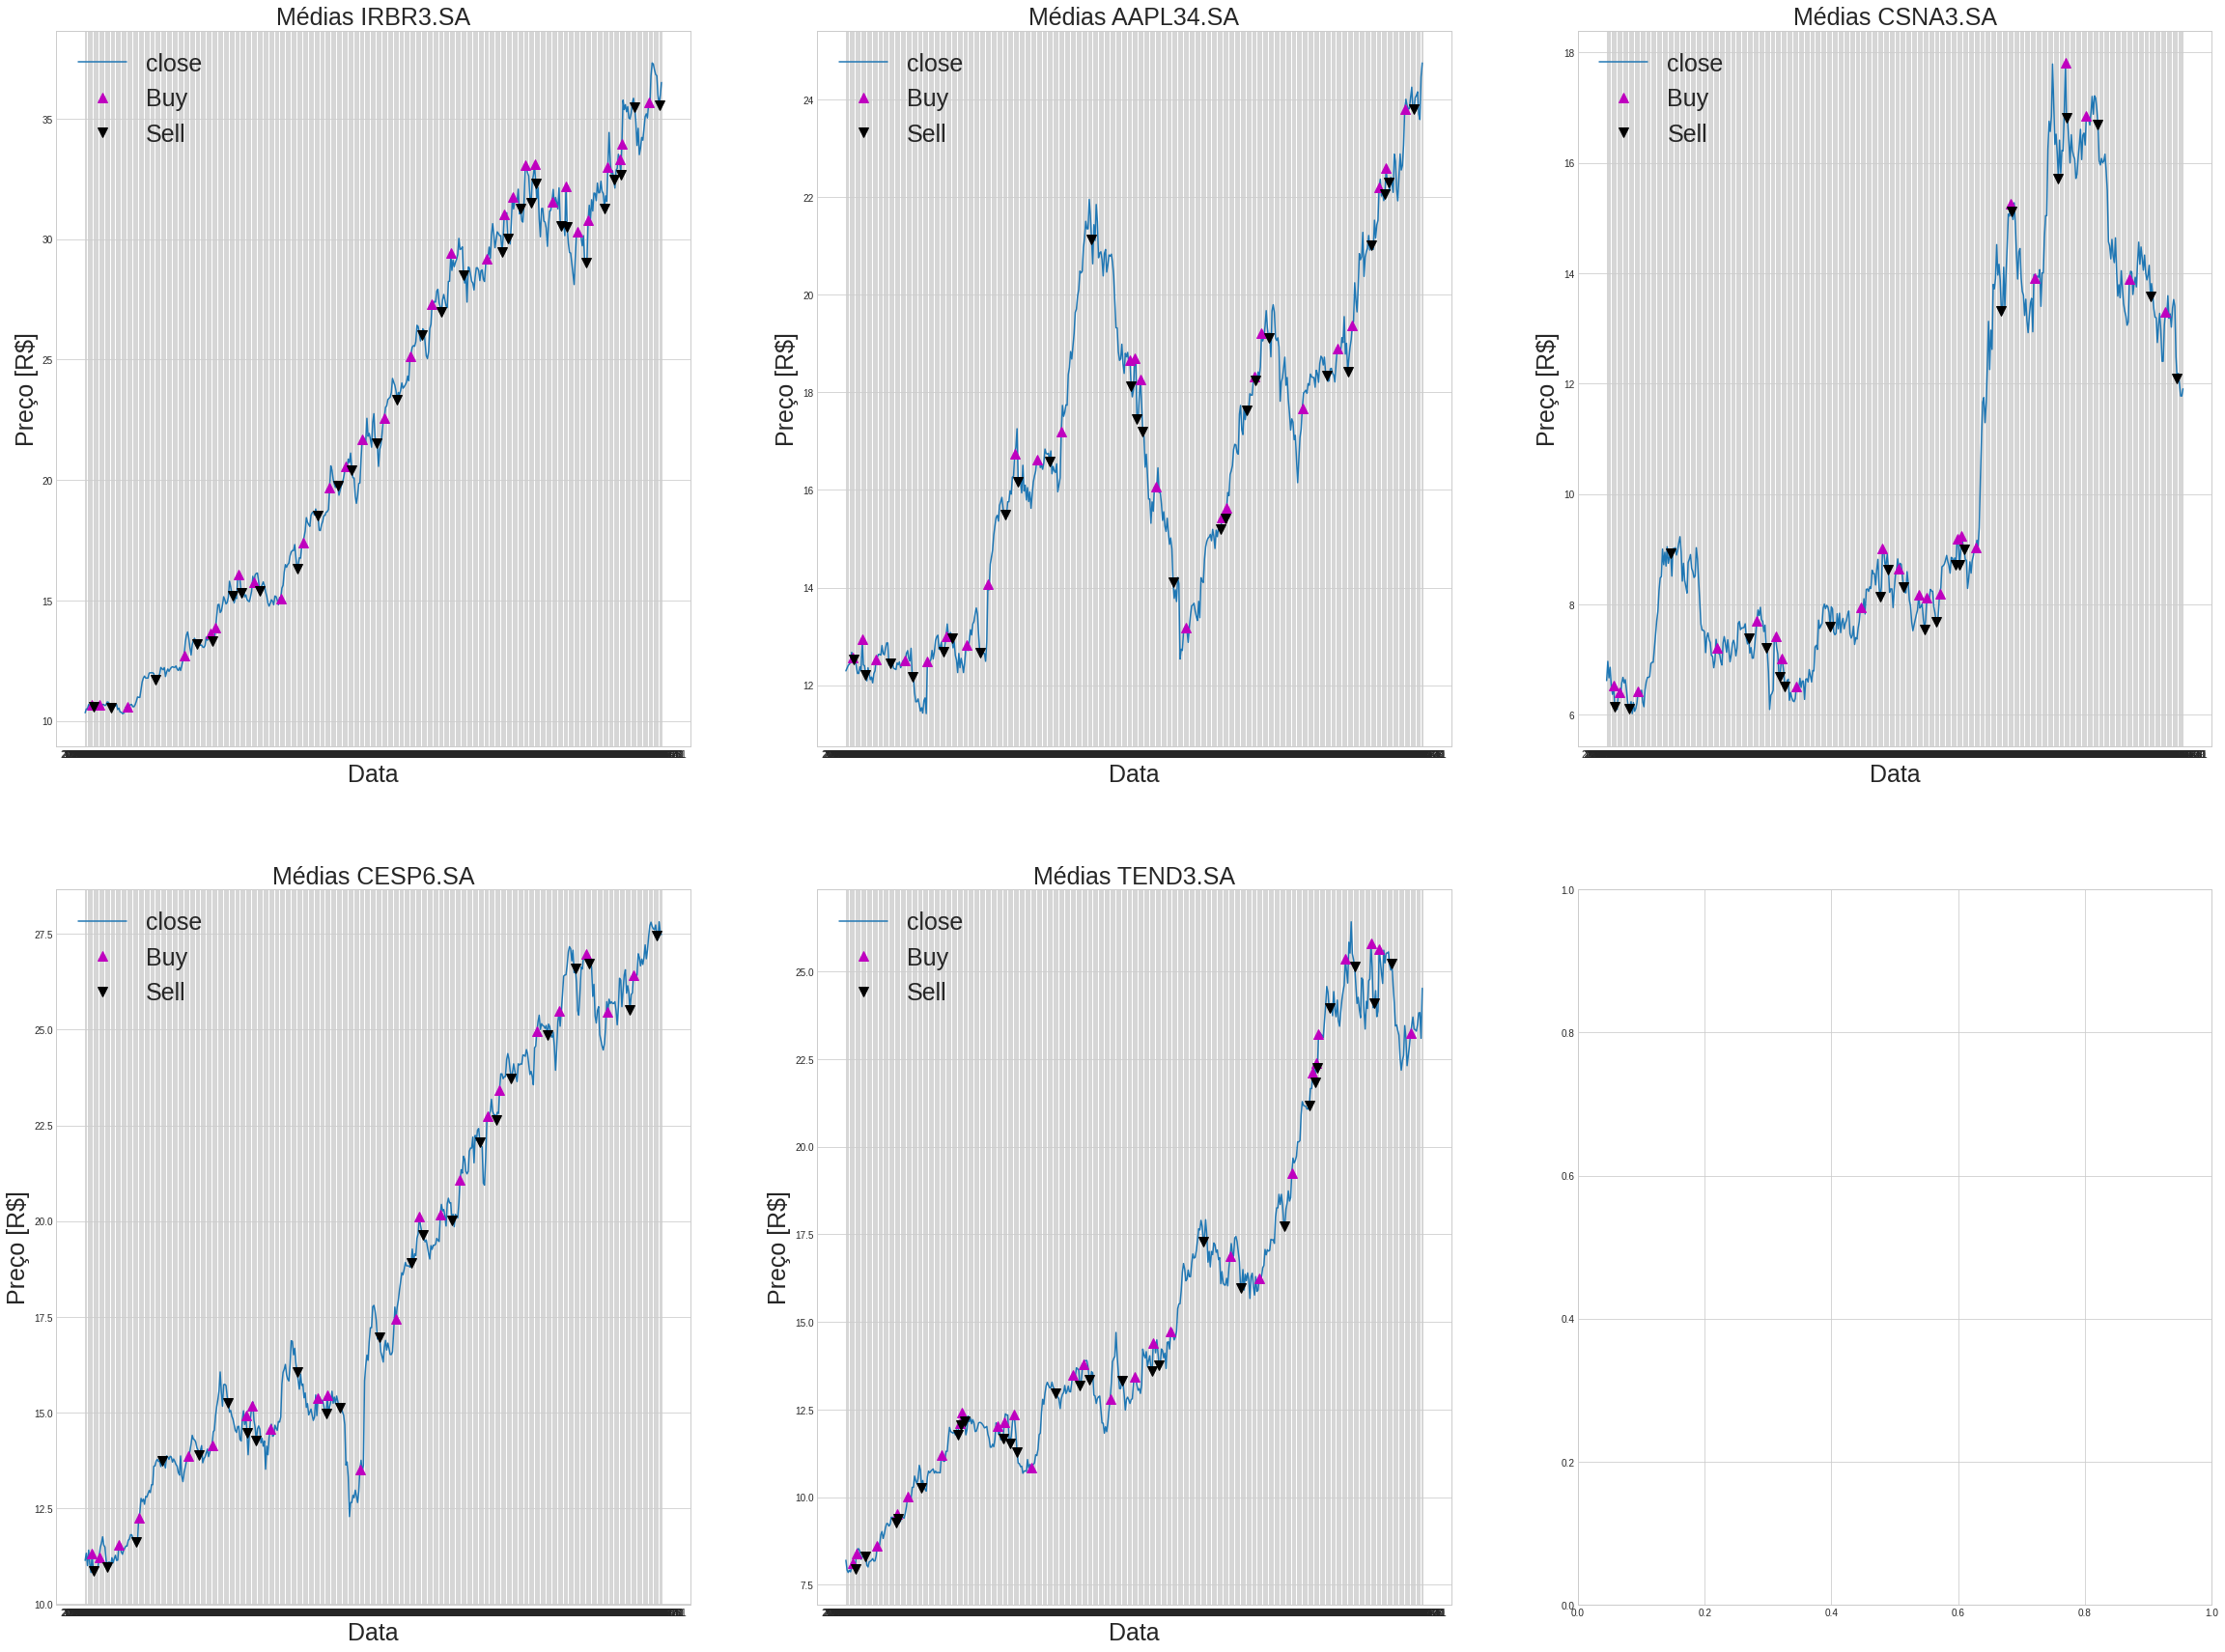

In [28]:
plot_buy_sell_macd(split_train)

## Test

In [29]:
get_info_invest(split_test, capital, posi)

ATIVO: IRBR3.SA RETORNO: -2568.22 ACERTO BUY: 4 ACERTO SELL: 5 TOTAL TRADES: 22 PERC_ACERTO: 40.909090909090914
ATIVO: AAPL34.SA RETORNO: 16736.53 ACERTO BUY: 3 ACERTO SELL: 7 TOTAL TRADES: 16 PERC_ACERTO: 62.5
ATIVO: CSNA3.SA RETORNO: 220.1 ACERTO BUY: 2 ACERTO SELL: 7 TOTAL TRADES: 31 PERC_ACERTO: 29.03225806451613
ATIVO: CESP6.SA RETORNO: -532.99 ACERTO BUY: 3 ACERTO SELL: 5 TOTAL TRADES: 28 PERC_ACERTO: 28.57142857142857
ATIVO: TEND3.SA RETORNO: 20.64 ACERTO BUY: 3 ACERTO SELL: 3 TOTAL TRADES: 20 PERC_ACERTO: 30.0
Total de lucro da carteira: 13876.06
Média de acerto: 35.9%


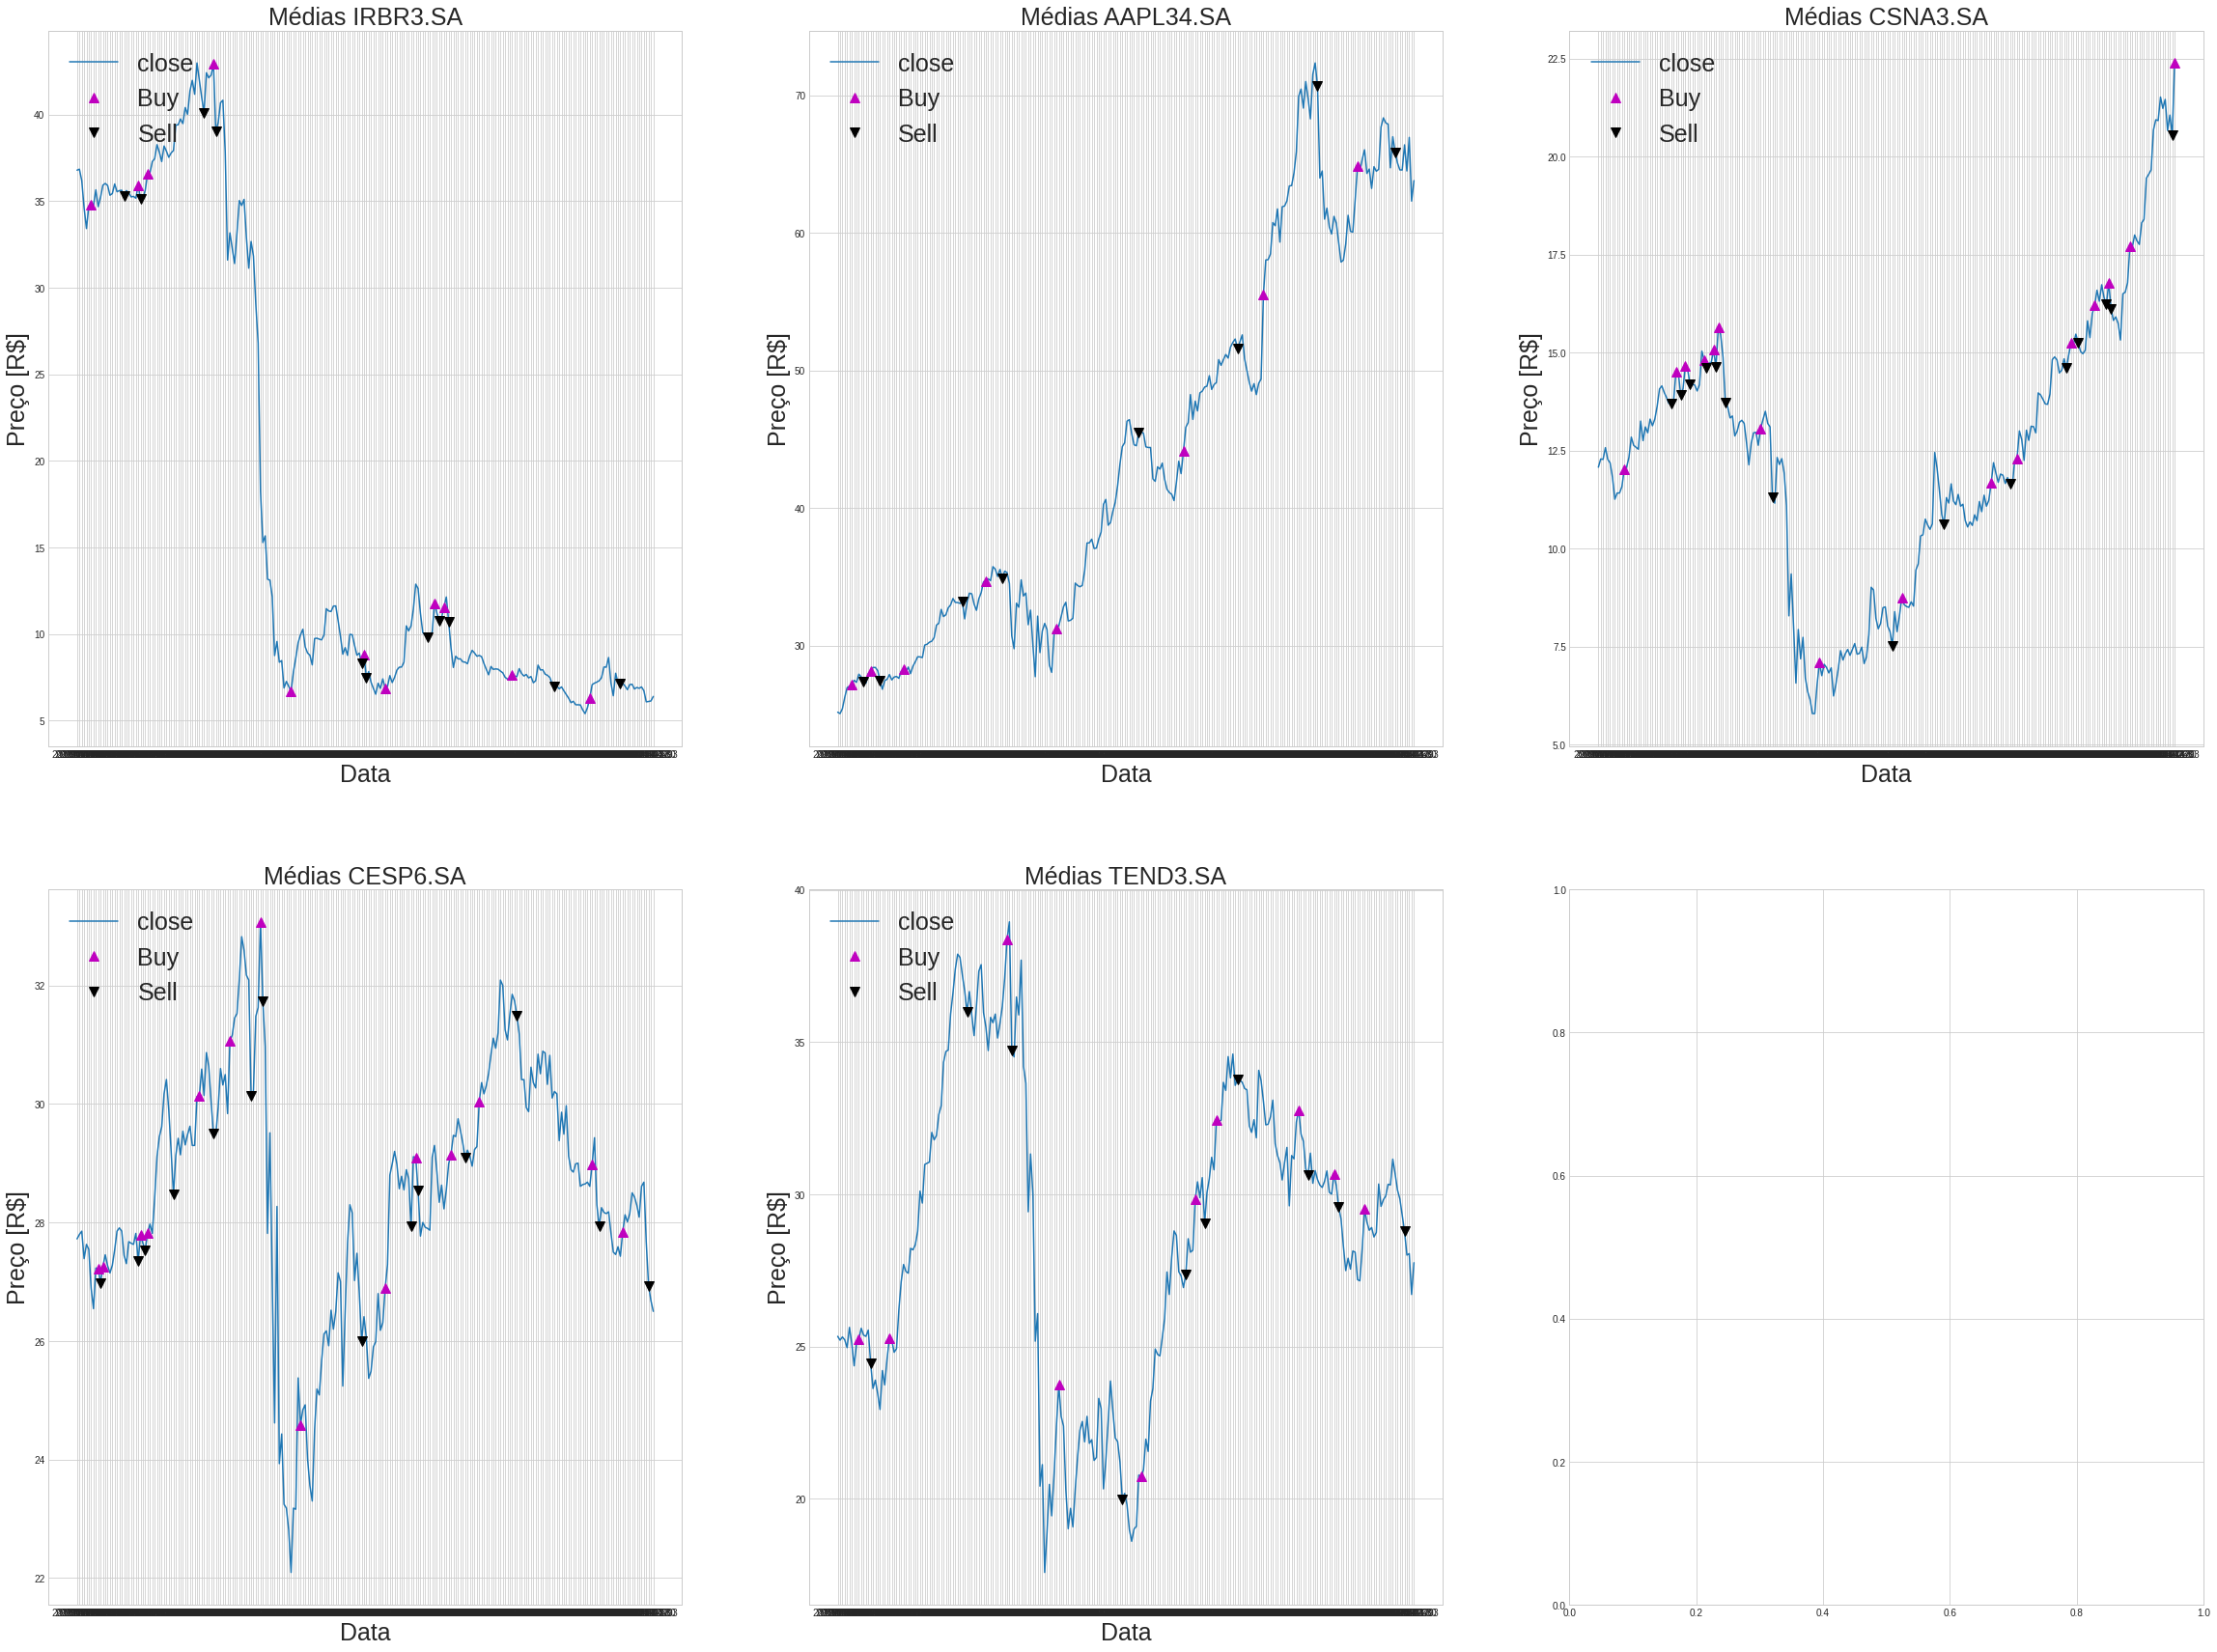

In [30]:
plot_buy_sell_macd(split_test)

In [31]:
trades = 0
for each in ativos:
    print("ATIVO: {} \tTRADES: {}".format(each, split_test[each]["position"][split_test[each]["position"] != 0].shape[0]))
    trades += split_test[each]["position"][split_test[each]["position"] != 0].shape[0]
print("Total trades: {}".format(trades))

ATIVO: IRBR3.SA 	TRADES: 22
ATIVO: AAPL34.SA 	TRADES: 16
ATIVO: CSNA3.SA 	TRADES: 31
ATIVO: CESP6.SA 	TRADES: 28
ATIVO: TEND3.SA 	TRADES: 20
Total trades: 117


<h1> Questão 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import investpy
import matplotlib.dates as mdates
from scipy import signal

df = investpy.get_stock_historical_data(stock='TEND3',
                                        country='Brazil',
                                        from_date='01/01/2017',
                                        to_date='19/11/2020')
print(df.tail())
print(len(df))

df1 = pd.DataFrame(index=df.index)
df1['open']=df.Open.values
df1['high']=df.High.values
df1['low']=df.Low.values
df1['close']=df.Close.values
df1['volume']= df.Volume.values
df1.reset_index(inplace=True)
df1['Date'] = df1['Date'].map(mdates.date2num)
df1=df1[['Date', 'open', 'high', 'low', 'close','volume']]

In [73]:
def ema(data, period=0, column='close'):
    data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()    
    return data


In [74]:
mean = 80


Text(0.5, 1.0, 'Gráfico do CandleSticks')

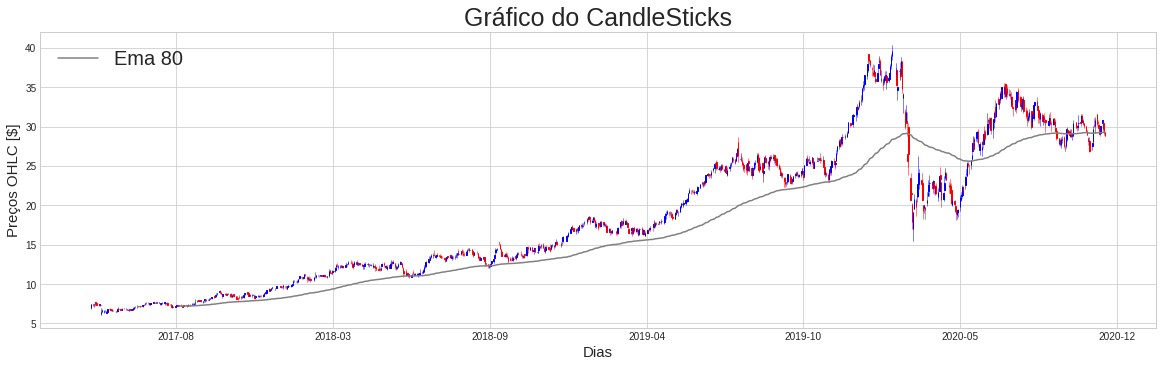

In [75]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
fig = plt.subplots(figsize=(20,12))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(211)
candlestick_ohlc(ax1, df1.values, width=0.6, colorup='b', colordown='r',alpha=1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.plot(df1['Date'], ema(df1,mean)['ema80'], color = 'gray', label = 'Ema 80')
ax1.legend(loc='upper left',fontsize=20)

ax1.set_xlabel("Dias",fontsize=15)
ax1.set_ylabel('Preços  [R$]',fontsize=15)
ax1.set_title('Gráfico do CandleSticks',fontsize=25) 

In [85]:
df1['Afastamento'] = df1['close']-df1['ema80']


In [166]:
df1=df1.drop('Afastamento medio',axis=1)

In [167]:
df1=df1.dropna()

In [168]:
df1

,Date,open,high,low,close,volume,ema80,Afastamento,signal,positions
79,17403.0,7.36,7.41,7.19,7.19,510600,7.212620,-0.022620,0.0,0.0
80,17406.0,7.24,7.42,7.18,7.22,722200,7.212764,0.007236,0.0,0.0
81,17407.0,7.26,7.29,7.17,7.22,850200,7.212904,0.007096,0.0,0.0
82,17408.0,7.24,7.26,7.08,7.15,1321400,7.211697,-0.061697,0.0,0.0
83,17409.0,7.17,7.35,7.15,7.32,648800,7.213761,0.106239,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
873,18579.0,29.18,30.13,29.07,30.13,444000,29.244941,0.885059,0.0,0.0
874,18582.0,30.41,30.79,29.40,30.79,874000,29.264016,1.525984,0.0,0.0
875,18583.0,30.52,30.74,29.75,29.80,854400,29.270634,0.529366,0.0,0.0
876,18584.0,29.95,30.00,28.90,29.19,820800,29.269638,-0.079638,0.0,0.0


In [163]:
# Sinal de Entrada
df1['signal_sell']=0
df1['signal_sell'] = np.where(df1['Afastamento'] > 3 , 1.0, 0.0)   

df1['signal_buy']=0

df1['signal_buy'] = np.where(df1['Afastamento'] < -3 , -1.0, 0.0)   

In [161]:
df1[df1['signal']>0]

,Date,open,high,low,close,volume,ema80,Afastamento medio,Afastamento,signal,positions
411,17903.0,16.53,17.00,16.46,17.00,1273800,13.536942,3.463058,3.463058,1.0,1.0
412,17904.0,17.02,17.27,16.87,17.25,2394600,13.583054,3.666946,3.666946,1.0,0.0
413,17905.0,17.32,17.47,16.87,17.09,1806600,13.626604,3.463396,3.463396,1.0,0.0
414,17906.0,16.92,17.13,16.74,16.74,1713200,13.665264,3.074736,3.074736,1.0,0.0
415,17907.0,17.09,17.09,16.70,16.79,629400,13.704062,3.085938,3.085938,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
811,18488.0,31.22,32.23,30.80,31.88,1046200,28.591119,3.288881,3.288881,1.0,1.0
815,18494.0,31.09,32.72,30.84,32.72,526100,28.729967,3.990033,3.990033,1.0,1.0
816,18495.0,32.78,33.15,32.01,33.12,1253300,28.784167,4.335833,4.335833,1.0,0.0
817,18498.0,33.30,33.70,32.24,32.32,1745400,28.827821,3.492179,3.492179,1.0,0.0


KeyError: 'signal_sell'

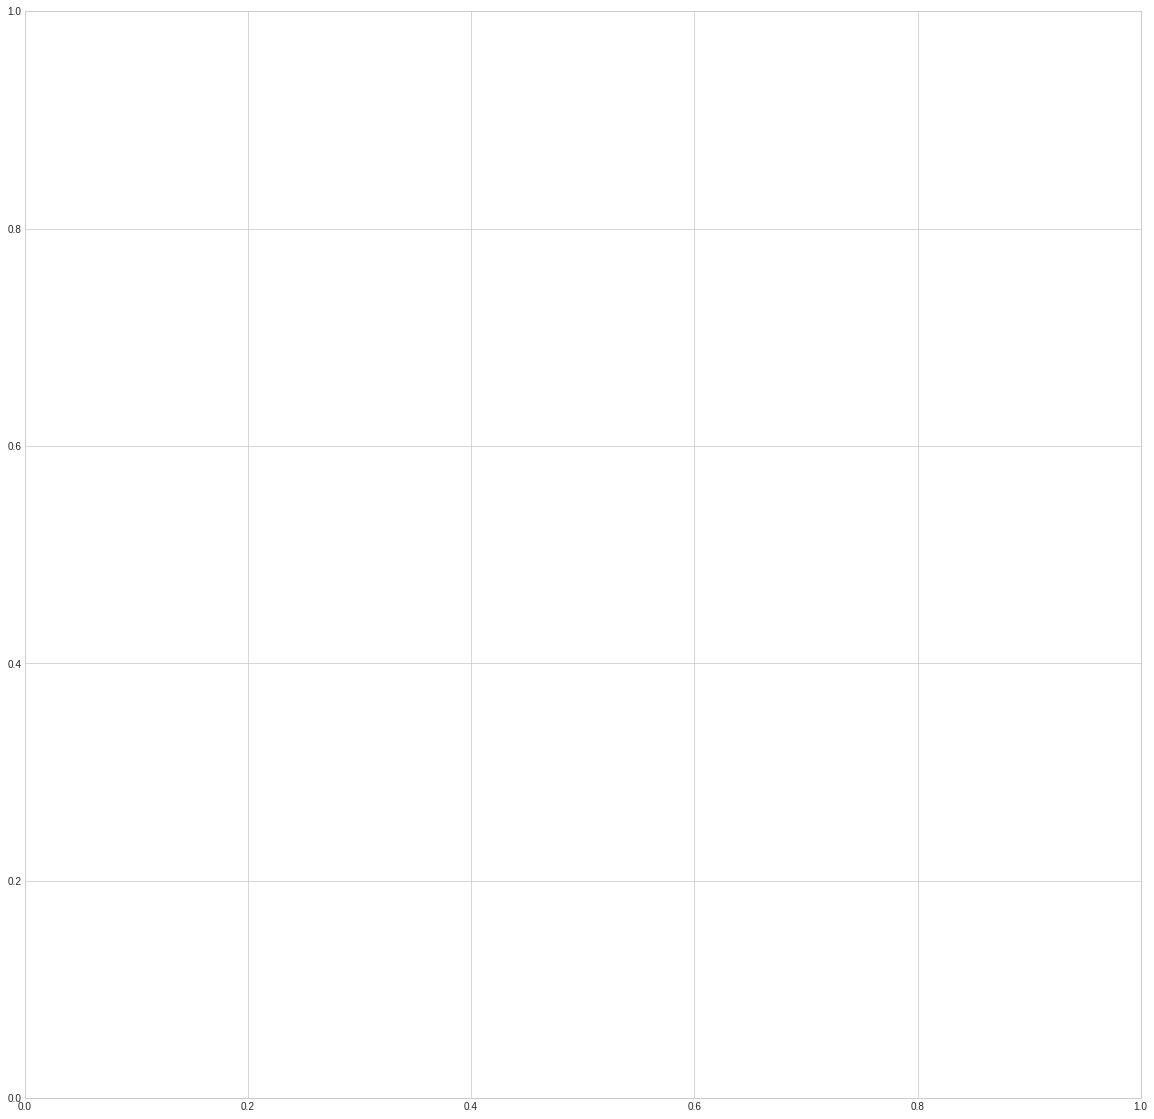

In [165]:
fig = plt.subplots(figsize=(20,20))
plt.style.use('seaborn-whitegrid')
df1=trades
# Posição dos trades
trades['positions_sell'] = trades['signal_sell'].diff()
trades['positions_buy'] = trades['signal_buy'].diff()



ax2 = plt.subplot(211)

ax2.plot(trades['close'], label='Close')

ax2.plot(trades[trades.positions == 1.0], 
         trades[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades.loc[trades.positions == -1.0], 
         trades[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Médias",fontsize=25)


In [106]:
trades.dropna()

,Date,open,high,low,close,volume,ema80,Afastamento medio,Afastamento,signal,positions
79,17403.0,7.36,7.41,7.19,7.19,510600,7.212620,-0.022620,-0.022620,0.0,0.0
80,17406.0,7.24,7.42,7.18,7.22,722200,7.212764,0.007236,0.007236,0.0,0.0
81,17407.0,7.26,7.29,7.17,7.22,850200,7.212904,0.007096,0.007096,0.0,0.0
82,17408.0,7.24,7.26,7.08,7.15,1321400,7.211697,-0.061697,-0.061697,0.0,0.0
83,17409.0,7.17,7.35,7.15,7.32,648800,7.213761,0.106239,0.106239,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
873,18579.0,29.18,30.13,29.07,30.13,444000,29.244941,0.885059,0.885059,0.0,0.0
874,18582.0,30.41,30.79,29.40,30.79,874000,29.264016,1.525984,1.525984,0.0,0.0
875,18583.0,30.52,30.74,29.75,29.80,854400,29.270634,0.529366,0.529366,0.0,0.0
876,18584.0,29.95,30.00,28.90,29.19,820800,29.269638,-0.079638,-0.079638,0.0,0.0


# Comparação dos resultados   

| Método | Retorno | Trades | % Acertos| Fator de Lucro | Índice Sharpe | Buy&Hold |
|---|---|---|---|---|---|---|
|Médias moveis|11196.3|204|39.0%||||
|MACD|13876.06|117|35.9%||||